In [1]:
# Import packages
import numpy as np
import pandas as pd
import chardet
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import string
import time

# Display plots inline
# matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVC

from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.preprocessing.text import one_hot
from keras.callbacks import ModelCheckpoint 

from scipy import sparse, stats

Using TensorFlow backend.


In [2]:
# Download nltk - only need to run once
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sheik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Get encoding of data file
with open("author_data.csv", 'rb') as file:
    print(chardet.detect(file.read()))

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


In [4]:
# Load data (uncomment relevant line)
# Local version
#data = pd.read_csv("author_data.csv", encoding="utf-8")

# Floydhub version
data = pd.read_csv("author_data.csv", encoding="utf-8")
print(data.head())

                                                text  author
0  She certainly had not been in the wrong, and h...  Austen
1  Why did you speak to him, Edgar?’  ‘I didn’t,’...  Bronte
2  "Don't praise me, Meg, for I could box his ear...  Alcott
3  And if I may win thee, yet shall thy lady be m...  Malory
4  Mina and I fear to be idle, so we have been ov...  Stoker


In [5]:
# Create feature (text) and label (author) lists
text = list(data['text'].values)
author = list(data['author'].values)

print("The author dataset contains {} datapoints.".format(len(text)))

The author dataset contains 52500 datapoints.


In [6]:
# Check distribution of authors in the data
Counter(author)

Counter({'Austen': 3500,
         'Bronte': 3500,
         'Alcott': 3500,
         'Malory': 3500,
         'Stoker': 3500,
         'Doyle': 3500,
         'Dickens': 3500,
         'Thatcher': 3500,
         'Berens': 3500,
         'Swift': 3500,
         'Sinclair': 3500,
         'Montgomery': 3500,
         'Grimm': 3500,
         'Twain': 3500,
         'Augustine': 3500})

In [7]:
print(text[2000])

And then Sir Ector told him all, how he was betaken him for to nourish him, and by whose commandment, and by Merlin’s deliverance.


In [8]:
print(text[4000])

He has been eight years upon a project for extracting sunbeams out of cucumbers, which were to be put in phials hermetically sealed, and let out to warm the air in raw inclement summers.


In [9]:
print(text[6000])

stop!


In [10]:
print(text[8000])

I pulled off my hat, and made a low bow towards the farmer.


In [11]:
print(text[10000])

In that case, nothing could be more pitiable or more honourable than the sacrifices she had resolved on.


In [12]:
print(text[20000])

Elizabeth jumped out; and, after giving each of them a hasty kiss, hurried into the vestibule, where Jane, who came running down from her mother's apartment, immediately met her.


In [13]:
print(text[30000])

He inherited his function as sun-god from Helios, with whom, in later times, he was so completely identified, that the personality of the one became gradually merged in that of the other.


In [14]:
print(text[40000])

I am amazed.’  ‘I was tired, father.


In [15]:
print(text[50000])

When he has burst forth in all the glorious light of day, Eos disappears, and Helios now drives his flame-darting chariot along the accustomed track.


In [16]:
# Create word count and character count lists
word_count = []
char_count = []

for i in range(len(text)):
    word_count.append(len(text[i].split()))
    char_count.append(len(text[i]))

# Convert lists to numpy arrays
word_count = np.array(word_count)
char_count = np.array(char_count)

# Calculate average word lengths
ave_length = np.array(char_count)/np.array(word_count)

In [17]:
def get_stats(var):
    
    print("Min:", np.min(var))
    print("Max:", np.max(var))
    print("Mean:", np.mean(var))
    print("Median", np.median(var))
    print("1st percentile", np.percentile(var, 1))
    print("95th percentile", np.percentile(var, 95))
    print("99th percentile", np.percentile(var, 99))
    print("99.5th Percentile", np.percentile(var, 99.5))
    print("99.9th Percentile", np.percentile(var, 99.9))

In [18]:
print("Word count statistics")
get_stats(word_count)

Word count statistics
Min: 1
Max: 577
Mean: 23.56144761904762
Median 19.0
1st percentile 1.0
95th percentile 59.0
99th percentile 94.0
99.5th Percentile 115.0
99.9th Percentile 169.50100000000384


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

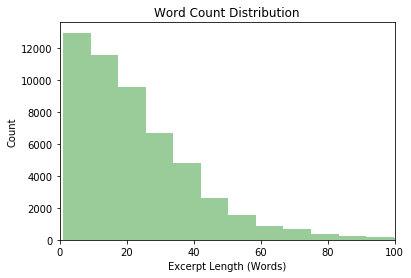

In [19]:
# Plot word count distribution
sns.distplot(word_count, kde = False, bins = 70, color = 'green').set_title("Word Count Distribution")
plt.xlabel('Excerpt Length (Words)')
plt.ylabel('Count')
plt.xlim(0, 100)
plt.savefig("word_count.eps")



In [20]:
print("\nCharacter count statistics")
get_stats(char_count)


Character count statistics
Min: 5
Max: 4560
Mean: 126.36028571428571
Median 100.0
1st percentile 8.0
95th percentile 322.0
99th percentile 508.0
99.5th Percentile 625.0099999999948
99.9th Percentile 922.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

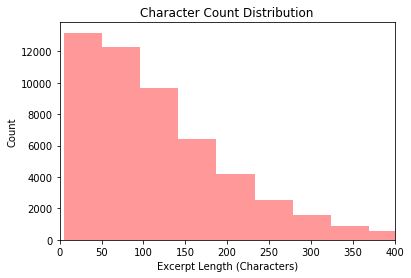

In [21]:
# Plot character count distribution
sns.distplot(char_count, kde = False, bins = 100, color = 'red').set_title("Character Count Distribution")
plt.xlabel('Excerpt Length (Characters)')
plt.ylabel('Count')
plt.xlim(0, 400)
plt.savefig("char_count.eps")

In [22]:
print("\nAverage length statistics")
get_stats(ave_length)


Average length statistics
Min: 2.5
Max: 18.0
Mean: 5.408808841261658
Median 5.3
1st percentile 4.0
95th percentile 6.666666666666667
99th percentile 8.666666666666666
99.5th Percentile 10.0
99.9th Percentile 12.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

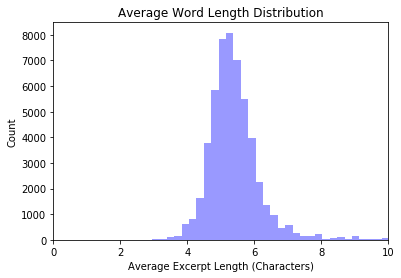

In [23]:
# Plot average excerpt length distribution
sns.distplot(ave_length, kde = False, bins = 70, color = 'blue').set_title("Average Word Length Distribution")
plt.xlabel('Average Excerpt Length (Characters)')
plt.ylabel('Count')
plt.xlim(0, 10)
plt.savefig("ave_length.eps")

In [24]:
# Get word count outliers
word_outliers = np.where(word_count > 150)

for i in word_outliers[0]:
    print("Excerpt {} - Length: {}".format(i, word_count[i]))
    print(text[i], "\n")

Excerpt 104 - Length: 162
he knows I have none, or he would not talk so.’  However, the fox bid him be of good cheer, and said, ‘I will help you; lie down there, stretch yourself out quite stiff, and pretend to be dead.’ The horse did as he was told, and the fox went straight to the lion who lived in a cave close by, and said to him, ‘A little way off lies a dead horse; come with me and you may make an excellent meal of his carcase.’ The lion was greatly pleased, and set off immediately; and when they came to the horse, the fox said, ‘You will not be able to eat him comfortably here; I’ll tell you what—I will tie you fast to his tail, and then you can draw him to your den, and eat him at your leisure.’  This advice pleased the lion, so he laid himself down quietly for the fox to make him fast to the horse. 

Excerpt 185 - Length: 162
he knows I have none, or he would not talk so.’  However, the fox bid him be of good cheer, and said, ‘I will help you; lie down there, stretch yourself o

In [25]:
word_outliers = np.where(word_count < 2)

for i in word_outliers[0]:
    print("Excerpt {} - Length: {}".format(i, word_count[i]))
    print(text[i], "\n")

Excerpt 7 - Length: 1
“Compeyson”. 

Excerpt 9 - Length: 1
“Yes. 

Excerpt 134 - Length: 1
“Noth'n”. 

Excerpt 164 - Length: 1
Good-night". 

Excerpt 230 - Length: 1
"Good! 

Excerpt 409 - Length: 1
VIII. 

Excerpt 466 - Length: 1
“Married! 

Excerpt 471 - Length: 1
‘There! 

Excerpt 522 - Length: 1
“Capital! 

Excerpt 528 - Length: 1
Where? 

Excerpt 628 - Length: 1
VESTALIA. 

Excerpt 652 - Length: 1
stop! 

Excerpt 676 - Length: 1
Answer! 

Excerpt 784 - Length: 1
Impossible”! 

Excerpt 918 - Length: 1
“Good. 

Excerpt 1089 - Length: 1
"P.S. 

Excerpt 1114 - Length: 1
“Hooray”! 

Excerpt 1169 - Length: 1
“Imitated”. 

Excerpt 1283 - Length: 1
NEPTUNE. 

Excerpt 1335 - Length: 1
“Ah”! 

Excerpt 1346 - Length: 1
Prince! 

Excerpt 1496 - Length: 1
Come!" 

Excerpt 1864 - Length: 1
“What? 

Excerpt 1901 - Length: 1
That”? 

Excerpt 1947 - Length: 1
VULCAN. 

Excerpt 1986 - Length: 1
‘Attentive? 

Excerpt 2061 - Length: 1
"Rather!" 

Excerpt 2139 - Length: 1
“Fudge! 

Excerpt 2166 - Leng

Excerpt 47397 - Length: 1
“Well”? 

Excerpt 47618 - Length: 1
“Precisely. 

Excerpt 47640 - Length: 1
"So!" 

Excerpt 47657 - Length: 1
i.-iv. 

Excerpt 47783 - Length: 1
‘Thank’ee. 

Excerpt 47988 - Length: 1
“Yes. 

Excerpt 48265 - Length: 1
‘God! 

Excerpt 48340 - Length: 1
ROBIGUS. 

Excerpt 48363 - Length: 1
There! 

Excerpt 48366 - Length: 1
‘Attentive? 

Excerpt 48417 - Length: 1
‘Nonsense! 

Excerpt 48436 - Length: 1
Spies”! 

Excerpt 48460 - Length: 1
“Pretty? 

Excerpt 48502 - Length: 1
“Yesterday”. 

Excerpt 48599 - Length: 1
JUPITER. 

Excerpt 48686 - Length: 1
“Good”! 

Excerpt 48726 - Length: 1
Hurry”! 

Excerpt 48842 - Length: 1
home! 

Excerpt 48928 - Length: 1
“Why? 

Excerpt 49023 - Length: 1
See!" 

Excerpt 49206 - Length: 1
CEREALIA. 

Excerpt 49307 - Length: 1
“Yes”. 

Excerpt 49442 - Length: 1
‘God! 

Excerpt 49473 - Length: 1
Gentleman. 

Excerpt 49520 - Length: 1
Amen. 

Excerpt 49590 - Length: 1
“Blacklisted”? 

Excerpt 49687 - Length: 1
Hush! 

Excerpt 49783 -

In [26]:
# Get average length outliers
length_outliers = np.where(ave_length > 10)

for i in length_outliers[0]:
    print("Excerpt {} - Average Length: {}".format(i, ave_length[i]))
    print(text[i], "\n")

Excerpt 7 - Average Length: 12.0
“Compeyson”. 

Excerpt 13 - Average Length: 14.333333333333334
Bellerophontes (bel-ler´-o-fon´-teez), 256. 

Excerpt 164 - Average Length: 12.0
Good-night". 

Excerpt 296 - Average Length: 10.5
Priamus (pri´-a-mus). 

Excerpt 784 - Average Length: 12.0
Impossible”! 

Excerpt 1066 - Average Length: 12.0
Læstrygones (les-trig´-o-neez), 311. 

Excerpt 1169 - Average Length: 11.0
“Imitated”. 

Excerpt 1669 - Average Length: 10.333333333333334
Musagetes (mu-saj´-e-teez), 71. 

Excerpt 1962 - Average Length: 11.333333333333334
Terpsichore (terp-sic´-o-re), 159. 

Excerpt 1986 - Average Length: 11.0
‘Attentive? 

Excerpt 2545 - Average Length: 11.0
Victorinus! 

Excerpt 2647 - Average Length: 17.666666666666668
Juliet..................................... Mr. Kean. 

Excerpt 3209 - Average Length: 14.0
“Astonishing”! 

Excerpt 3374 - Average Length: 11.0
“Only four-and-twenty. 

Excerpt 3423 - Average Length: 10.333333333333334
Orithyia (or´-i-thi´-yah), 171. 


In [27]:
length_outliers = np.where(ave_length < 3.5)

for i in length_outliers[0]:
    print("Excerpt {} - Average Length: {}".format(i, ave_length[i]))
    print(text[i], "\n")

Excerpt 170 - Average Length: 3.0
Go on! 

Excerpt 179 - Average Length: 3.0
Go on! 

Excerpt 667 - Average Length: 3.3333333333333335
Woe is me! 

Excerpt 2357 - Average Length: 3.0
Not I. 

Excerpt 2688 - Average Length: 3.0
Oh no! 

Excerpt 3794 - Average Length: 3.1666666666666665
er is a cow a cat”? 

Excerpt 3807 - Average Length: 3.0
I say! 

Excerpt 4320 - Average Length: 3.3333333333333335
By and by he got it. 

Excerpt 5887 - Average Length: 3.4285714285714284
Who am I, and what am I? 

Excerpt 9205 - Average Length: 3.2
What am I to do? 

Excerpt 11904 - Average Length: 3.0
I say! 

Excerpt 13339 - Average Length: 3.375
But I'll do it ef I got to. 

Excerpt 16126 - Average Length: 3.25
So I done it. 

Excerpt 16236 - Average Length: 3.0
Is a cow a man? 

Excerpt 16525 - Average Length: 3.25
So I done it. 

Excerpt 16836 - Average Length: 3.0
“Yes . 

Excerpt 17056 - Average Length: 3.3333333333333335
Let us go. 

Excerpt 17384 - Average Length: 3.4285714285714284
“I do not g

In [28]:
# Create string containing all excerpts in lower case
text_string = ''

for i in range(len(text)):
    text_string += text[i].lower()

# Get character frequencies
char_cnt = Counter(text_string)
print(char_cnt)
print(len(char_cnt))

Counter({' ': 1192095, 'e': 649561, 't': 473897, 'a': 418986, 'o': 394964, 'n': 357341, 'h': 353679, 'i': 348021, 's': 319670, 'r': 298294, 'd': 244415, 'l': 205048, 'u': 147521, 'm': 134976, 'w': 131094, 'f': 113300, 'c': 112693, ',': 109671, 'g': 107602, 'y': 106072, 'p': 79169, 'b': 78806, '.': 51422, 'v': 48094, 'k': 43034, '’': 13497, ';': 12941, "'": 8242, 'j': 7789, '“': 6983, '-': 6936, '”': 6677, '‘': 6675, 'x': 6221, '?': 5113, '"': 4857, '!': 4503, 'q': 4369, ':': 3632, '—': 2767, 'z': 2468, ')': 1492, '(': 1477, '1': 1146, '2': 922, '´': 695, '0': 503, '3': 490, '[': 442, ']': 442, '4': 412, '8': 403, '5': 393, '6': 377, '7': 367, '*': 341, '9': 316, 'æ': 270, 'œ': 77, 'ë': 49, 'ï': 42, '&': 36, '£': 25, '\xa0': 17, 'ă': 16, 'ŏ': 15, 'ö': 13, 'ā': 9, '#': 6, 'é': 6, 'è': 4, '–': 4, 'ô': 3, 'â': 2, '\ufeff': 2, '/': 2, 'ĭ': 1, 'ê': 1, '$': 1, '=': 1})
80


In [29]:
# Get character count dictionary keys
print(list(char_cnt.keys()))

['s', 'h', 'e', ' ', 'c', 'r', 't', 'a', 'i', 'n', 'l', 'y', 'd', 'o', 'b', 'w', 'g', ',', 'u', 'v', '.', 'p', 'k', 'm', '?', '’', '‘', 'f', '-', '"', "'", 'x', ':', '“', '”', 'j', ';', 'q', '!', 'z', '(', '´', ')', '2', '5', '6', '—', '1', '8', '0', 'œ', '4', '7', '&', '3', '[', ']', '9', 'ŏ', 'æ', '*', 'ï', 'ë', 'ö', '#', '£', 'é', '\xa0', 'ā', 'ĭ', 'ă', 'â', 'è', '\ufeff', '–', 'ô', 'ê', '$', '=', '/']


In [30]:
# Create list of accented characters
accented_chars = ['ï', 'é', 'ñ', 'è', 'ö', 'æ', 'ô', 'â', 'á', 'à', 'ê', 'ë']

# Find all texts containing unusual characters
accented_text = []

for i in range(len(text)):
    for j in text[i]:
        if j in accented_chars:
            accented_text.append(i)
        
accented_text = list(set(accented_text))
 
print('There are', str(len(accented_text)), 'texts containing accented characters.')

There are 301 texts containing accented characters.


In [31]:
# Print accented texts
for i in accented_text:
    print("Excerpt {}".format(i))
    print(text[i] + '\n')

Excerpt 7681
In order to avenge the oppression of her children, the Giants, Gæa instigated a conspiracy on the part of the Titans against Uranus, which was carried to a successful issue by her son Cronus.

Excerpt 19969
When, having grown to manhood, he now returned to his father's palace, his young stepmother, Phædra, fell violently in love with him; but Hippolytus failed to return her affection, and treated her with contempt and indifference.

Excerpt 37894
OLYMPIAN DIVINITIES—  Zeus (Jupiter), 26  Hera (Juno), 38  Pallas-Athene (Minerva), 43  Themis, 48  Hestia (Vesta), 48  Demeter (Ceres), 50  Aphrodite (Venus), 58  Helios (Sol), 61  Eos (Aurora), 67  Phœbus-Apollo, 68  Hecate, 85  Selene (Luna), 86  Artemis (Diana), 87  Hephæstus (Vulcan), 97  Poseidon (Neptune), 101  [iv] SEA DIVINITIES—  Oceanus, 107  Nereus, 108  Proteus, 108  Triton and the Tritons, 109  Glaucus, 109  Thetis, 110  Thaumas, Phorcys, and Ceto, 111  Leucothea, 111  The Sirens, 112  Ares (Mars), 112  Nike (Victori

In [32]:
# Remove invalid character from text
text = [excerpt.replace('\xa0', '') for excerpt in text]

In [33]:
# Verify character has been removed
unusual_text = []

for i in range(len(text)):
    for j in text[i]:
        if j == '\xa0':
            unusual_text.append(i)
        
unusual_text = list(set(unusual_text))
 
print('There are', str(len(unusual_text)), 'texts containing the invalid character.')

There are 0 texts containing the invalid character.


In [34]:
# Count texts containing white space blocks
ctr = 0
for excerpt in text:
    if "  " in excerpt:
        ctr += 1

print('There are', ctr, 'excerpts containing blocks of white space.')

There are 3265 excerpts containing blocks of white space.


In [35]:
# Remove blocks of white space
new_text = []

for excerpt in text:
    while "  " in excerpt:
        excerpt = excerpt.replace("  "," ")
    new_text.append(excerpt)

text = new_text
print(len(text))

52500


In [36]:
ctr = 0
for excerpt in text:
    if "  " in excerpt:
        ctr += 1

print('There are', ctr, 'excerpts containing blocks of white space.')

There are 0 excerpts containing blocks of white space.


In [37]:
normed_text = []

for i in range(len(text)):
    new = text[i].lower()
    new = new.translate(str.maketrans('','', string.punctuation))
    new = new.replace('“', '').replace('”', '')
    normed_text.append(new)
    
print(normed_text[0:5])    
print(len(normed_text))

['she certainly had not been in the wrong and he would never own that he had', 'why did you speak to him edgar’ ‘i didn’t’ sobbed the youth escaping from my hands and finishing the remainder of the purification with his cambric pockethandkerchief', 'dont praise me meg for i could box his ears this minute', 'and if i may win thee yet shall thy lady be mine and thou shalt lose thy head', 'mina and i fear to be idle so we have been over all the diaries again and again']
52500


In [38]:
text_train, text_test, author_train, author_test = train_test_split(normed_text, author, test_size = 0.2, random_state = 5)

In [39]:
# Check shapes of created datasets
print(np.shape(text_train))
print(np.shape(text_test))
print(np.shape(author_train))
print(np.shape(author_test))

(42000,)
(10500,)
(42000,)
(10500,)


In [40]:
def create_n_grams(excerpt_list, n, vocab_size, seq_size):
    """Create a list of n-gram sequences
    
    Args:
    excerpt_list: list of strings. List of normalized text excerpts.
    n: int. Length of n-grams.
    vocab_size: int. Size of n-gram vocab (used in one-hot encoding)
    seq_size: int. Size of n-gram sequences
    
    Returns:
    n_gram_array: array. Numpy array of one-hot encoded n-grams.
    """
    n_gram_list = []

    for excerpt in excerpt_list:
        # Remove spaces
        excerpt = excerpt.replace(" ", "")

        # Extract n-grams
        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        # Convert to a single string with spaces between n-grams
        new_string = " ".join(n_grams)

        # One hot encode
        hot = one_hot(new_string, round(vocab_size*1.3))

        # Pad hot if necessary
        hot_len = len(hot)
        if hot_len >= seq_size:
            hot = hot[0:seq_size]
        else:
            diff = seq_size - hot_len
            extra = [0]*diff
            hot = hot + extra

        n_gram_list.append(hot)
    
    n_gram_array = np.array(n_gram_list)
    
    return n_gram_array

In [41]:
def get_vocab_size(excerpt_list, n, seq_size):
    
    n_gram_list = []

    for excerpt in excerpt_list:
        # Remove spaces
        excerpt = excerpt.replace(" ", "")

        # Extract n-grams           
        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        # Create list of n-grams
        gram_len = len(n_grams)
        if gram_len >= seq_size:
            n_grams = n_grams[0:seq_size]
        else:
            diff = seq_size - gram_len
            extra = [0]*diff
            n_grams = n_grams + extra
        
        n_gram_list.append(n_grams)
    
    # Flatten n-gram list
    n_gram_list = list(np.array(n_gram_list).flat)
    
    # Calculate vocab size
    n_gram_cnt = Counter(n_gram_list)
    vocab_size = len(n_gram_cnt)
    
    return vocab_size

In [42]:
# Determine vocab sizes

for i in range(1, 4):
    vocab_size = get_vocab_size(text_train, i, 350)
    print('Vocab size for n =', i, 'is:', vocab_size)

Vocab size for n = 1 is: 57
Vocab size for n = 2 is: 1341
Vocab size for n = 3 is: 12779


In [43]:
# Create n-gram lists
gram1_train = create_n_grams(text_train, 1, 51, 350)
gram2_train = create_n_grams(text_train, 2, 966, 350)
gram3_train = create_n_grams(text_train, 3, 9521, 350)

gram1_test = create_n_grams(text_test, 1, 51, 350)
gram2_test = create_n_grams(text_test, 2, 966, 350)
gram3_test = create_n_grams(text_test, 3, 9521, 350)

print(np.shape(gram1_train))
print(np.shape(gram2_train))
print(np.shape(gram3_train))

print(np.shape(gram1_test))
print(np.shape(gram2_test))
print(np.shape(gram3_test))

(42000, 350)
(42000, 350)
(42000, 350)
(10500, 350)
(10500, 350)
(10500, 350)


In [44]:
# Determine maximum value of n-gram encodings (this is used to set the CNN embedding dimension)
max_1gram = np.max(gram1_train)
max_2gram = np.max(gram2_train)
max_3gram = np.max(gram3_train)

print('Maximum encoding value for 1-grams is: ', max_1gram)
print('Maximum encoding value for 2-grams is: ', max_2gram)
print('Maximum encoding value for 3-grams is: ', max_3gram)

Maximum encoding value for 1-grams is:  65
Maximum encoding value for 2-grams is:  1254
Maximum encoding value for 3-grams is:  12375


In [45]:
def process_data(excerpt_list):
    
    stop_words = set(stopwords.words('english'))
    porter = PorterStemmer()
    
    processed = []
    
    for excerpt in excerpt_list:
        new = excerpt.split()
        word_list = [porter.stem(w) for w in new if not w in stop_words]
        word_list = " ".join(word_list)
        processed.append(word_list)
    
    return processed

In [46]:
# Process data subsets
processed_train = process_data(text_train)
processed_test = process_data(text_test)

print(processed_train[0:5])

['good pip observ conclud ill go round present pay friend', 'box gone', 'point', 'time chast godli sober widow thou lovest cheer hope yet whit relax weep mourn ceas hour devot bewail case unto thee', 'morn appear breakfast usual hour took usual place tabl']


In [47]:
# Create bag of words features
## Fit Tfidf Vectorizer
vectorizer = TfidfVectorizer(strip_accents = 'ascii', stop_words = 'english', min_df = 6)
vectorizer.fit(processed_train)

# Get size of vocabulary
print('Vocabulary size: ', len(vectorizer.vocabulary_))

# Create feature vectors
words_train = vectorizer.transform(processed_train)
words_test = vectorizer.transform(processed_test)

Vocabulary size:  6512


In [48]:
# One hot encode labels
author_lb = LabelBinarizer()

author_lb.fit(author_train)
author_train_hot = author_lb.transform(author_train)
author_test_hot = author_lb.transform(author_test)

In [49]:
# Define model architecture in keras
def define_model(input_len, output_size, vocab_size, embedding_dim, verbose = True,
                drop_out_pct = 0.25, conv_filters = 500, activation_fn = 'relu', pool_size = 2, learning = 0.0001):
    
    # Channel 1
    inputs1 = Input(shape = (input_len,))
    embedding1 = Embedding(vocab_size, embedding_dim)(inputs1)
    drop1 = Dropout(drop_out_pct)(embedding1)
    conv1 = Conv1D(filters = conv_filters, kernel_size = 3, activation = activation_fn)(drop1)
    pool1 = MaxPooling1D(pool_size = pool_size)(conv1)
    flat1 = Flatten()(pool1)
    
    # Channel 2
    inputs2 = Input(shape = (input_len,))
    embedding2 = Embedding(vocab_size, embedding_dim)(inputs2)
    drop2 = Dropout(drop_out_pct)(embedding2)
    conv2 = Conv1D(filters = conv_filters, kernel_size = 4, activation = activation_fn)(drop2)
    pool2 = MaxPooling1D(pool_size = pool_size)(conv2)
    flat2 = Flatten()(pool2)

    # Channel 3
    inputs3 = Input(shape = (input_len,))
    embedding3= Embedding(vocab_size, embedding_dim)(inputs3)
    drop3 = Dropout(drop_out_pct)(embedding3)
    conv3 = Conv1D(filters = conv_filters, kernel_size = 5, activation = activation_fn)(drop3)
    pool3 = MaxPooling1D(pool_size = pool_size)(conv3)
    flat3 = Flatten()(pool3)
    
    # Merge channels
    merged = concatenate([flat1, flat2, flat3])
    
    # Create output layer
    output = Dense(output_size, activation = 'softmax')(merged)
    
    # Create model
    model = Model(inputs = [inputs1, inputs2, inputs3], outputs = output)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr = learning), metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
        
    return model

In [50]:
# Create the 1-gram model
gram1_model = define_model(350, 15, max_1gram + 1, 26)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 350, 26)      1716        input_1[0][0]                    
____________________________________________________________________________________________

In [51]:
# Train 1-gram CNN
gram1_model.fit([gram1_train, gram1_train, gram1_train], author_train_hot, epochs=3, batch_size=32, 
                verbose = 1, validation_split = 0.2)

C:\Users\sheik\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 33600 samples, validate on 8400 samples
Epoch 1/3
33600/33600 [==============================] - 874s 26ms/step - loss: 2.6029 - accuracy: 0.1329 - val_loss: 2.4819 - val_accuracy: 0.1990
Epoch 2/3
33600/33600 [==============================] - 744s 22ms/step - loss: 2.2866 - accuracy: 0.2654 - val_loss: 2.2216 - val_accuracy: 0.2830
Epoch 3/3
33600/33600 [==============================] - 748s 22ms/step - loss: 2.0345 - accuracy: 0.3480 - val_loss: 2.1279 - val_accuracy: 0.3146


In [52]:
# Create the 2-gram model
gram2_model = define_model(350, 15, max_2gram + 1, 300)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 350, 300)     376500      input_4[0][0]                    
____________________________________________________________________________________________

In [ ]:
# Train 2-gram CNN
gram2_model.fit([gram2_train, gram2_train, gram2_train], author_train_hot, epochs=3, batch_size=32, 
                verbose = 1, validation_split = 0.2)

C:\Users\sheik\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 33600 samples, validate on 8400 samples
Epoch 1/3
33600/33600 [==============================] - 2659s 79ms/step - loss: 2.4818 - accuracy: 0.1851 - val_loss: 2.1284 - val_accuracy: 0.3107
Epoch 2/3
25216/33600 [=====================>........] - ETA: 9:47 - loss: 1.8767 - accuracy: 0.3956

In [54]:
# Create the 3-gram model
gram3_model = define_model(350, 15, max_3gram + 1, 600)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 350)          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 350, 600)     7426200     input_7[0][0]                    
____________________________________________________________________________________________

In [55]:
# Train 3-gram CNN
gram3_model.fit([gram3_train, gram3_train, gram3_train], author_train_hot, epochs=5, batch_size=32, 
                verbose = 1, validation_split = 0.2)

C:\Users\sheik\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 33600 samples, validate on 8400 samples
Epoch 1/5
33600/33600 [==============================] - 5860s 174ms/step - loss: 2.4494 - accuracy: 0.1982 - val_loss: 1.9948 - val_accuracy: 0.3579
Epoch 2/5
33600/33600 [==============================] - 6197s 184ms/step - loss: 1.5562 - accuracy: 0.5118 - val_loss: 1.4492 - val_accuracy: 0.5424
Epoch 3/5
33600/33600 [==============================] - 4959s 148ms/step - loss: 0.9951 - accuracy: 0.7021 - val_loss: 1.2302 - val_accuracy: 0.6124
Epoch 4/5
33600/33600 [==============================] - 4914s 146ms/step - loss: 0.6711 - accuracy: 0.8091 - val_loss: 1.1953 - val_accuracy: 0.6332
Epoch 5/5
33600/33600 [==============================] - 4927s 147ms/step - loss: 0.4648 - accuracy: 0.8730 - val_loss: 1.1234 - val_accuracy: 0.6671


In [56]:
# Define grid search object
svm = SVC()
params = {'kernel': ['linear'], 'C':[1, 10, 100]}
scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(svm, params, scoring = scorer, verbose = 50)

In [57]:
# Fit bag of words svm
np.random.seed(6)
word_svm = grid_obj.fit(words_train, author_train)

C:\Users\sheik\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.656, total= 2.0min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.660, total= 1.9min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s
[CV] C=1, kernel=linear ..............................................
[CV] .................. C=1, kernel=linear, score=0.663, total= 1.9min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.7min remaining:    0.0s
[CV] C=10, kernel=linear .............................................
[CV] ................. C=10, kernel=linear, score=0.650, total= 1.8min
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:

In [58]:
print(word_svm.best_estimator_)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


In [59]:
print(word_svm.cv_results_)

{'mean_fit_time': array([77.64812072, 73.39578493, 86.5236268 ]), 'std_fit_time': array([1.64422512, 0.5672338 , 0.72950077]), 'mean_score_time': array([37.03349789, 35.17660721, 36.09208107]), 'std_score_time': array([0.38584772, 0.4358237 , 0.51622258]), 'param_C': masked_array(data=[1, 10, 100],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_kernel': masked_array(data=['linear', 'linear', 'linear'],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1, 'kernel': 'linear'}, {'C': 10, 'kernel': 'linear'}, {'C': 100, 'kernel': 'linear'}], 'split0_test_score': array([0.65555159, 0.64976794, 0.63927169]), 'split1_test_score': array([0.66026145, 0.65454675, 0.63697407]), 'split2_test_score': array([0.66333238, 0.6584024 , 0.64054015]), 'mean_test_score': array([0.65971429, 0.6542381 , 0.63892857]), 'std_test_score': array([0.00320002, 0.00353182, 0.00147581]), 'rank_test_score': arr

In [60]:
# Define model architecture in keras
def define_model2(input_len, output_size, vocab_size, embedding_dim, verbose = True,
                drop_out_pct = 0.25, conv_filters = 500, activation_fn = 'relu', pool_size = 2, learning = 0.0001):
    
    # Channel 1
    inputs1 = Input(shape = (input_len,))
    embedding1 = Embedding(vocab_size, embedding_dim)(inputs1)
    drop1 = Dropout(drop_out_pct)(embedding1)
    conv1 = Conv1D(filters = conv_filters, kernel_size = 3, activation = activation_fn)(drop1)
    pool1 = MaxPooling1D(pool_size = pool_size)(conv1)
    flat1 = Flatten()(pool1)
    
    # Channel 2
    inputs2 = Input(shape = (input_len,))
    embedding2 = Embedding(vocab_size, embedding_dim)(inputs2)
    drop2 = Dropout(drop_out_pct)(embedding2)
    conv2 = Conv1D(filters = conv_filters, kernel_size = 4, activation = activation_fn)(drop2)
    pool2 = MaxPooling1D(pool_size = pool_size)(conv2)
    flat2 = Flatten()(pool2)

    # Channel 3
    inputs3 = Input(shape = (input_len,))
    embedding3= Embedding(vocab_size, embedding_dim)(inputs3)
    drop3 = Dropout(drop_out_pct)(embedding3)
    conv3 = Conv1D(filters = conv_filters, kernel_size = 5, activation = activation_fn)(drop3)
    pool3 = MaxPooling1D(pool_size = pool_size)(conv3)
    flat3 = Flatten()(pool3)
    
    # Channel 4
    inputs4 = Input(shape = (input_len,))
    embedding4 = Embedding(vocab_size, embedding_dim)(inputs4)
    drop4 = Dropout(drop_out_pct)(embedding4)
    conv4 = Conv1D(filters = conv_filters, kernel_size = 6, activation = activation_fn)(drop4)
    pool4 = MaxPooling1D(pool_size = pool_size)(conv4)
    flat4 = Flatten()(pool4)
    
    # Merge channels
    merged = concatenate([flat1, flat2, flat3, flat4])
    
    # Create output layer
    output = Dense(output_size, activation = 'softmax')(merged)
    
    # Create model
    model = Model(inputs = [inputs1, inputs2, inputs3, inputs4], outputs = output)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr = learning), metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
        
    return model

In [61]:
# Create the 3-gram model
gram3_model2 = define_model2(350, 15, max_3gram + 1, 600)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 350)          0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 350)          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 350)          0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, 350)          0                                            
____________________________________________________________________________________________

In [ ]:
# Train 3-gram CNN
gram3_model2.fit([gram3_train, gram3_train, gram3_train, gram3_train], author_train_hot, epochs=3, batch_size=32, 
                verbose = 1, validation_split = 0.2)

C:\Users\sheik\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 33600 samples, validate on 8400 samples
Epoch 1/3
33600/33600 [==============================] - 7365s 219ms/step - loss: 2.4152 - accuracy: 0.2095 - val_loss: 1.9352 - val_accuracy: 0.3738
Epoch 2/3
21280/33600 [==================>...........] - ETA: 43:17 - loss: 1.5390 - accuracy: 0.5271

In [ ]:
# Define function for plotting normalized confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
       
    df_cm = pd.DataFrame(cm, index = classes,
                  columns = classes)
    sns.heatmap(df_cm, annot=True, cmap = cmap)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)


In [ ]:
# Fit and evaluate Model 1 (3-gram CNN)

t0 = time.time()

# Fit model
model1 = define_model(350, 15, max_3gram + 1, 600)
model1.fit([gram3_train, gram3_train, gram3_train], author_train_hot, epochs=3, batch_size=32, 
           verbose = 1, validation_split = 0.2)
t1 = time.time()
 
# Predict values for test set
author_pred1 = model1.predict([gram3_test, gram3_test, gram3_test])

t2 = time.time()

# Reverse one-hot encoding of labels
author_pred1 = author_lb.inverse_transform(author_pred1)

# Evaluate
accuracy = accuracy_score(author_test, author_pred1)
precision, recall, f1, support = score(author_test, author_pred1)
ave_precision = np.average(precision, weights = support/np.sum(support))
ave_recall = np.average(recall, weights = support/np.sum(support))
ave_f1 = np.average(f1, weights = support/np.sum(support))
confusion = confusion_matrix(author_test, author_pred1, labels = ['Dickens', 'Montgomery', 'Stoker', 'Austen', 
                                                                  'Grimm', 'Swift','Thatcher', 'Twain','Malory',
                                                                 'Alcott', 'Berens', 'Doyle', 'Augustine', 'Thoreau',
                                                                 'Sinclair', 'Bronte'])
    
print("Accuracy:", accuracy)
print("Ave. Precision:", ave_precision)
print("Ave. Recall:", ave_recall)
print("Ave. F1 Score:", ave_f1)
print("Training Time:", (t1 - t0), "seconds")
print("Prediction Time:", (t2 - t1), "seconds")
print("Confusion Matrix:\n", confusion)

In [67]:
# Plot normalized confusion matrix
plot_confusion_matrix(confusion, classes=['Dickens', 'Montgomery', 'Stoker', 'Austen','Grimm', 'Swift','Thatcher', 'Twain','Malory',
                                            'Alcott', 'Berens', 'Doyle', 'Augustine', 'Thoreau','Sinclair', 'Bronte'], \
                      normalize=True, title='Normalized Confusion Matrix - Model 1')

plt.savefig("confusion1.eps")

NameError: name 'confusion' is not defined